In [121]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from typing import Tuple

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## Load stock data

In [30]:
stock_list = ['AMZN']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [31]:
data = AMZN
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-24,976.000000,981.000000,970.229980,980.349976,980.349976,2446000
2017-05-25,984.849976,999.000000,982.109985,993.380005,993.380005,4822000
2017-05-26,995.000000,998.650024,989.250000,995.780029,995.780029,3469200
2017-05-30,996.510010,1001.200012,995.520020,996.700012,996.700012,3263100
2017-05-31,1000.000000,1000.119995,982.159973,994.619995,994.619995,3913100


## Build transformer

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1261 entries, 2017-05-24 to 2022-05-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1261 non-null   float64
 1   High       1261 non-null   float64
 2   Low        1261 non-null   float64
 3   Close      1261 non-null   float64
 4   Adj Close  1261 non-null   float64
 5   Volume     1261 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.0 KB


In [180]:
# # https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# class PositionalEncoder(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [191]:
class PositionalEncoder(nn.Module):
    """
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    https://github.com/LiamMaclean216/Pytorch-Transfomer/blob/master/utils.py 
    """

    def __init__(self, d_model: int = 512, dropout: float = 0.1, max_len: int = 5000):

        """
        Args:
            dropout: the dropout rate
            max_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        # Create constant positional encoding matrix with values 
        # dependent on position and i
        position = torch.arange(max_len).unsqueeze(1)
        
        exp_input = torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        
        pe = torch.zeros(max_len, d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])

        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])

        # register that pe is not a model parameter
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val]
        """

        add = self.pe[:x.size(1), :].squeeze(1)

        x = x + add

        return self.dropout(x)

In [221]:
d_model: int = 512
max_len: int = 28
batch_size = 32


data = torch.rand((batch_size, max_len, d_model))
print(data.shape)
encoder = PositionalEncoder(d_model=d_model, max_len=max_len)
out = encoder(data)
print(out.shape)


torch.Size([32, 28, 512])
torch.Size([32, 28, 512])


In [231]:
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size: int,
        dec_seq_len: int,
        max_seq_len: int,
        out_seq_len: int=58,
        dim_val: int=512,
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
    ):

        """
        Args:
            input_size: int, the number of input variables
            dec_seq_len: int, length of decoder input
            max_seq_len: int, longest sequence the model will process, used for positional encoding
            out_seq_len: int, length of the target sequence, i.e. how many time steps should your forecast cover
            dim_val: int, number of expected features in the input
            n_encoder_layers: int, number of decoder layers in decoder
            n_decoder_layers: int, number of encoder layers in encoder
            n_heads: int, number of attention heads, dim_val must be divisible by this number
            dropout_encoder: float, dropout rate of the encoder
            dropout_decoder: float, dropout rate of the decoder
            dropout_pos_enc: float, dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in feed forward layer inside the encoder layers
            dim_feedforward_decoder: int, number of neurons in feed forward layer inside the decoder layers
        """
        super().__init__()

        self.dec_seq_len = dec_seq_len

        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
        )

        self.decoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
        )

        self.linear_mapping = nn.Linear(
            in_features=out_seq_len*dim_val,
            out_features=out_seq_len
        )

        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_len=max_seq_len
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=True
        )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
        )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, tgt_mask: Tensor=None) -> Tensor:
        """
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the feature number
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, E is the feature number.
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """
        # print(f"In shape encoder_input_layer: {src.shape}")
        src = self.encoder_input_layer(src)
        # print(f"In shape positional_encoding_layer: {src.shape}")
        src = self.positional_encoding_layer(src)
        # print(f"In shape encoder: {src.shape}")
        src = self.encoder(src)
        # print(f"In shape decoder_input_layer: {src.shape}")

        decoder_output = self.decoder_input_layer(tgt)
        # print(f"In shape decoder: {decoder_output.shape}")
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
        )
        # print(f"In shape linear_mapping: {decoder_output.shape}")
        decoder_output = self.linear_mapping(decoder_output.flatten(start_dim=1))
        # print(f"Shape decoder_output: {decoder_output.shape}")
        return decoder_output



In [194]:
## Model parameters
dim_val = 512 # number of expected features in the input
n_heads = 8 # number of attention heads, dim_val must be divisible by this number
n_decoder_layers = 4 # number of decoder layers in decoder
n_encoder_layers = 4 # number of encoder layers in encoder
input_size = 1 # number of input variables
dec_seq_len = 92 # length of decoder input
enc_seq_len = 153 # length of encoder input
output_sequence_length = 58 # length of target sequence, i.e. how many time steps should your forecast cover
in_features_encoder_linear_layer = 2048 # number of neurons in feed forward layer inside the encoder layers
in_features_decoder_linear_layer = 2048 # number of neurons in feed forward layer inside the decoder layers
max_seq_len = enc_seq_len # longest sequence the model will process, used for positional encoding
dropout_encoder = 0.2 # dropout rate of the encoder
dropout_decoder = 0.2 # dropout rate of the decoder
dropout_pos_enc = 0.2 # dropout rate of the positional encoder

model = TimeSeriesTransformer(
  input_size=input_size,  
  dec_seq_len=dec_seq_len,
  max_seq_len=max_seq_len,
  out_seq_len=output_sequence_length,
  dim_val=dim_val,   
  n_decoder_layers=n_decoder_layers,
  n_encoder_layers=n_encoder_layers,
  n_heads=n_heads,
  dropout_encoder=dropout_encoder,
  dropout_decoder=dropout_decoder,
  dropout_pos_enc=dropout_pos_enc,
  dim_feedforward_encoder=in_features_encoder_linear_layer,
  dim_feedforward_decoder=in_features_decoder_linear_layer
)

In [38]:
def get_src_trg(
    sequence: torch.Tensor, 
    enc_seq_len: int, 
    dec_seq_len: int, 
    target_seq_len: int
    ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

    """
    Generate the src (encoder input), trg (decoder input) and trg_y (the target)
    sequences from a sequence. 
    Args:
        sequence: tensor, a 1D tensor of length n where n = encoder input length + target sequence length  
        enc_seq_len: int, the desired length of the input to the transformer encoder
        target_seq_len: int, the desired length of the target sequence (the one against which the model output is compared)
    Return: 
        src: tensor, 1D, used as input to the transformer model
        trg: tensor, 1D, used as input to the transformer model
        trg_y: tensor, 1D, the target sequence against which the model output is compared when computing loss. 
    """
    assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"

    # encoder input
    src = sequence[:enc_seq_len] 

    # decoder input. As per the paper, it must have the same dimension as the 
    # target sequence, and it must contain the last value of src, and all
    # values of trg_y except the last (i.e. it must be shifted right by 1)
    trg = sequence[enc_seq_len-1:len(sequence)-1]

    assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

    # The target sequence against which the model output will be compared to compute loss
    trg_y = sequence[-target_seq_len:]

    assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

    return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 

In [112]:
def split_to_sequences(enc_seq_len, back_len, forward_len, features, target_column):
    seq_len = enc_seq_len + forward_len + forward_len
    data = features[target_column].to_numpy()

    src, trg, trg_y = [], [], []
    for i in range(seq_len, len(data)):
        subset = data[i-seq_len:i]
        src_data = subset[0:enc_seq_len]
        # print(src_data)
        trg_data = subset[enc_seq_len-back_len:enc_seq_len+forward_len]
        trg_y_data = subset[enc_seq_len+forward_len-back_len:enc_seq_len+forward_len+forward_len]
        src.append(src_data)
        trg.append(trg_data)
        trg_y.append(trg_y_data)

    return np.array(src), np.array(trg), np.array(trg_y)

In [113]:
# Define some hyperparameters
enc_seq_len = 4 # length of input given to encoder
shiftn_forward = 1 # shift forward
shift_backward = 1 # shift backward

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
})
src, trg, trg_y = split_to_sequences(enc_seq_len, 1, 1, df, "c")
print(src)
print(trg)
print(trg_y)

[[ 100  200  300  400]
 [ 200  300  400  500]
 [ 300  400  500  600]
 [ 400  500  600  700]
 [ 500  600  700  800]
 [ 600  700  800  900]
 [ 700  800  900 1000]
 [ 800  900 1000 1100]
 [ 900 1000 1100 1200]
 [1000 1100 1200 1300]
 [1100 1200 1300 1400]
 [1200 1300 1400 1500]
 [1300 1400 1500 1600]
 [1400 1500 1600 1700]]
[[ 400  500]
 [ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]]
[[ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]
 [1800 1900]]


In [28]:
dummy_data = torch.rand(10)
# dummy_data = torch.rand((32, 10, 5))

# Define some hyperparameters
enc_seq_len = 4 # length of input given to encoder
dec_seq_len = 2 # length of input given to decoder
target_seq_len = 5 # the desired length of the model forecast

# Make a sub-sequence from the dummy data
sub_sequence = dummy_data[0:enc_seq_len+target_seq_len]

# Get src, trg, trg_y
src, trg, trg_y = get_src_trg(
    sequence=sub_sequence,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=target_seq_len
    )

print(f"Data shape: {dummy_data.shape}")
print(f"src shape: {src.shape}")
print(f"trg shape: {trg.shape}")
print(f"trg_y shape: {trg_y.shape}")

print(f"Data: {dummy_data}")
print(f"src: {src}")
print(f"trg: {trg}")
print(f"trg_y: {trg_y}")

Data shape: torch.Size([10])
src shape: torch.Size([4])
trg shape: torch.Size([5])
trg_y shape: torch.Size([5])
Data: tensor([0.2737, 0.7650, 0.4902, 0.2242, 0.4586, 0.7979, 0.5540, 0.4362, 0.9602,
        0.4843])
src: tensor([0.2737, 0.7650, 0.4902, 0.2242])
trg: tensor([0.2242, 0.4586, 0.7979, 0.5540, 0.4362])
trg_y: tensor([0.4586, 0.7979, 0.5540, 0.4362, 0.9602])


In [226]:
def generate_square_subsequent_mask(dim1: int, dim2: int, dim3: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, batch_size * n_heads
        dim2: int. For src and trg masking this must be target sequence length. 
        dim3: int. For src masking, this must be encoder sequence length.
              For trg masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2, dim3]
    """
    return torch.triu(torch.ones(dim1, dim2, dim3) * float('-inf'), diagonal=1)

def _generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Input length
enc_seq_len = 2

# Output length
output_sequence_length = 3

# Heads in attention layers
n_heads = 4

batch_size = 5

# Make src mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, enc_seq_len]
src_mask = generate_square_subsequent_mask(
    dim1=batch_size*n_heads,
    dim2=output_sequence_length,
    dim3=enc_seq_len
    )

# Make tgt mask for decoder with size:
# [batch_size*n_heads, output_sequence_length, output_sequence_length]
tgt_mask = generate_square_subsequent_mask( 
    dim1=batch_size*n_heads,
    dim2=output_sequence_length,
    dim3=output_sequence_length
    )

print(f"Target mask shape: {tgt_mask.shape}")
print(f"Target mask shape: {tgt_mask}")
print(f"Source mask shape: {src_mask.shape}")

Target mask shape: torch.Size([20, 3, 3])
Target mask shape: tensor([[[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -inf, -inf],
         [0., 0., -inf],
         [0., 0., 0.]],

        [[0., -

In [216]:
def create_loader(src, trg, trg_y, batch_size = 64, shuffle=False):
    src_tensor = torch.unsqueeze(torch.tensor(src), 2).float()
    trg_tensor = torch.unsqueeze(torch.tensor(trg), 2).float()
    trg_y_tensor = torch.tensor(trg_y).float()
    dataset = TensorDataset(src_tensor, trg_tensor, trg_y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

## Train model

In [135]:
def normalize_data(df, column_scalers, is_fit=False):
    features = pd.DataFrame()
    for scaler, columns in column_scalers:
        if is_fit:
            values = df[columns].to_numpy().flatten()
            scaler.fit(values.reshape(-1, 1))
        for column in columns:
            data = df[column].values.reshape(-1, 1)
            scaled_data = scaler.transform(data)
            features["ft_" + column] = scaled_data.reshape(1, -1)[0]
    return features

In [131]:
def split_data(df, valid_split = 0.1, test_split=0.1):
    indexes = sorted(df.index.values)
    # first index of test data
    test_index = indexes[-int(test_split * len(indexes))]
    # first index of validation data
    valid_index = indexes[-int((test_split + valid_split) * len(indexes))]

    # split data to train, test and validation dataframes
    train_df = df[(df.index < valid_index)]
    # valid_df = df[np.logical_and(company.index >= valid_index, company.index < test_index)]
    valid_df = df[(df.index >= valid_index) & (df.index < test_index)]
    test_df = df[(df.index >= test_index)]
    print(f"Train splitted data shape: {train_df.shape}")
    print(f"Valid splitted data shape: {valid_df.shape}")
    print(f"Test splitted data shape: {test_df.shape}")
    return train_df, valid_df, test_df

In [250]:
def prepare_data(df, scalers, seq_len = 4 * 7, target_column = "Adj Close", batch_size = 64):
    train, valid, test = split_data(df)
    train = normalize_data(train, scalers, True)
    valid = normalize_data(valid, scalers)
    test = normalize_data(test, scalers)
    # draw_feature_split(target_column, train, valid, test)
    # # split_to_sequences(enc_seq_len, back_len, forward_len, features, target_column)
    src_train, trg_train, trg_y_train = split_to_sequences(seq_len, 1, 1, train, target_column)
    src_valid, trg_valid, trg_y_valid = split_to_sequences(seq_len, 1, 1, valid, target_column)
    src_test, trg_test, trg_y_test = split_to_sequences(seq_len, 1, 1, test, target_column)
    # X_test, y_test = split_to_sequences(seq_len, test, target_column)
    loader_train = create_loader(src_train, trg_train, trg_y_train, batch_size, shuffle=False)
    # loader_train_normal = create_loader(X_train, y_train)
    loader_valid = create_loader(src_valid, trg_valid, trg_y_valid, batch_size)
    loader_test = create_loader(src_test, trg_test, trg_y_test, batch_size)
    # loader_test = create_loader(X_test, y_test)
    # return loader_train, loader_valid, loader_test, loader_train_normal
    return loader_train, loader_valid, loader_test

In [450]:
# train model
def train(dataloader, model, src_mask, tgt_mask, loss_fn, optimizer, clip_gradient, batch_size, n_heads):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (src, trg, y) in enumerate(dataloader, 1):
        # print(f"Batch: {batch}")
        # print(f"Src shape: {src.shape}")
        # print(f"Trg shape: {trg.shape}")
        # print(f"Y shape: {trg.shape}")
        optimizer.zero_grad()
        # Compute prediction error
        if batch_size != src.shape[0]:
            src_mask = src_mask[:src.shape[0]*n_heads]
            tgt_mask = tgt_mask[:src.shape[0]*n_heads]
        pred = model(src, trg, src_mask, tgt_mask)
        # print(f"Pred shape: {pred.shape}")
        # print(f"Y shape: {y.shape}")
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        loss.backward()
        if clip_gradient is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return train_loss

In [242]:
# test model
def test(dataloader, model, src_mask, tgt_mask, loss_fn, batch_size, n_heads):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for src, trg, y in dataloader:
            if batch_size != src.shape[0]:
                src_mask = src_mask[:src.shape[0]*n_heads]
                tgt_mask = tgt_mask[:src.shape[0]*n_heads]
            pred = model(src, trg, src_mask, tgt_mask)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f"\nTest loss: {test_loss:>8f}")
    return test_loss

In [243]:
def train_model(model, src_mask, tgt_mask, loader_train, loader_valid, epochs=30, lr=0.0001, clip_gradient = None, batch_size=32, n_heads=8):
    loss_fn = nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss = train(loader_train, model, src_mask, tgt_mask, loss_fn, optimizer, clip_gradient, batch_size, n_heads)
        valid_loss = test(loader_valid, model, src_mask, tgt_mask, loss_fn, batch_size, n_heads)

        print(f"Epoch {epoch + 1} train loss: {train_loss}")
        print(f"Epoch {epoch + 1} valid loss: {valid_loss}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    return train_losses, valid_losses

In [254]:
def predict(model, src_mask, tgt_mask, loaders, batch_size, n_heads):
    model.eval()
    predictions = np.array([])
    original = np.array([])
    with torch.no_grad():
        for loader in loaders:
            for src, trg, y in loader:
                s_mask = src_mask
                t_mask = tgt_mask
                if batch_size != src.shape[0]:
                    s_mask = src_mask[:src.shape[0]*n_heads]
                    t_mask = tgt_mask[:src.shape[0]*n_heads]
                pred = model(src, trg, s_mask, t_mask)
                pred = torch.squeeze(pred, dim=1)
                predictions = np.append(predictions, pred.numpy())
                original = np.append(original, y.numpy())
    return original, predictions

In [142]:
def plot_losses(train_loss, valid_loss):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Model loss (MSE)", fontsize=22)
    st.set_y(0.92)

    ax1 = fig.add_subplot(311)
    ax1.plot(train_loss[0:], label='Training loss (MSE)')
    ax1.plot(valid_loss[0:], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12) 

In [249]:
def draw_prediction(original, predictions=None):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Transformer predictions", fontsize=22)
    st.set_y(0.92)

    ax11 = fig.add_subplot(311)
    ax11.plot(original, label='Original')
    if not predictions is None:
        ax11.plot(predictions, linewidth=3, label='Predicted')
    ax11.set_title("Training Data", fontsize=18)
    ax11.set_xlabel('Date')
    ax11.set_ylabel('Close price')
    ax11.legend(loc="best", fontsize=12)

In [468]:
feature_columns = ["Adj Close"]
seq_len = 8 * 7
batch_size = 32
scalers = [
    (MinMaxScaler(), ["Adj Close"])
]

# features_df = normalize_data(EPAM, scalers)
loader_train, loader_valid, loader_test = prepare_data(AMZN[feature_columns], scalers, seq_len = seq_len, target_column = "ft_Adj Close", batch_size = batch_size)

Train splitted data shape: (1009, 1)
Valid splitted data shape: (126, 1)
Test splitted data shape: (126, 1)


In [257]:
## Model parameters
dim_val = 128 # number of expected features in the input
n_heads = 8 # number of attention heads, dim_val must be divisible by this number
n_decoder_layers = 4 # number of decoder layers in decoder
n_encoder_layers = 4 # number of encoder layers in encoder
input_size = 1 # number of input variables //TODO ???
dec_seq_len = 2 # length of decoder input
enc_seq_len = seq_len # length of encoder input
output_sequence_length = 2 # length of target sequence, i.e. how many time steps should your forecast cover
in_features_encoder_linear_layer = 512 # number of neurons in feed forward layer inside the encoder layers
in_features_decoder_linear_layer = 512 # number of neurons in feed forward layer inside the decoder layers
max_seq_len = seq_len # longest sequence the model will process, used for positional encoding
dropout_encoder = 0.1 # dropout rate of the encoder
dropout_decoder = 0.1 # dropout rate of the decoder
dropout_pos_enc = 0.1 # dropout rate of the positional encoder

model = TimeSeriesTransformer(
  input_size=input_size,  
  dec_seq_len=dec_seq_len,
  max_seq_len=max_seq_len,
  out_seq_len=output_sequence_length,
  dim_val=dim_val,   
  n_decoder_layers=n_decoder_layers,
  n_encoder_layers=n_encoder_layers,
  n_heads=n_heads,
  dropout_encoder=dropout_encoder,
  dropout_decoder=dropout_decoder,
  dropout_pos_enc=dropout_pos_enc,
  dim_feedforward_encoder=in_features_encoder_linear_layer,
  dim_feedforward_decoder=in_features_decoder_linear_layer
)

Epoch 1
-------------------------------
Train loss: 0.404005

Test loss: 0.028741
Epoch 1 train loss: 0.40400537466930764
Epoch 1 valid loss: 0.02874069722990195
Epoch 2
-------------------------------
Train loss: 0.209113

Test loss: 0.089110
Epoch 2 train loss: 0.20911315960749502
Epoch 2 valid loss: 0.08910977592070897
Epoch 3
-------------------------------
Train loss: 0.204541

Test loss: 0.007257
Epoch 3 train loss: 0.20454124253123038
Epoch 3 valid loss: 0.007257283044358094
Epoch 4
-------------------------------
Train loss: 0.149586

Test loss: 0.009962
Epoch 4 train loss: 0.1495856575427517
Epoch 4 valid loss: 0.009961992812653383
Epoch 5
-------------------------------
Train loss: 0.176187

Test loss: 0.026735
Epoch 5 train loss: 0.17618699828463216
Epoch 5 valid loss: 0.02673451540370782
Epoch 6
-------------------------------
Train loss: 0.198453

Test loss: 0.022027
Epoch 6 train loss: 0.19845325779169798
Epoch 6 valid loss: 0.022026843080917995
Epoch 7
------------------

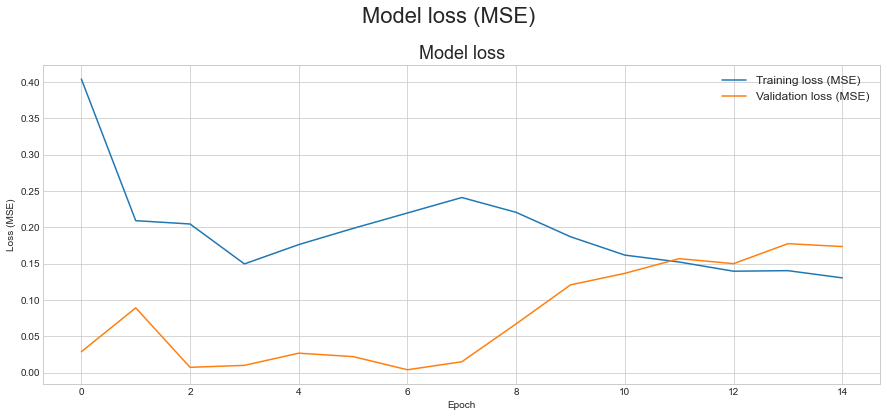

In [258]:
epochs = 15

# dim1: int, batch_size * n_heads
# dim2: int. For src and trg masking this must be target sequence length. 
# dim3: int. For src masking, this must be encoder sequence length.
#       For trg masking, this must be target sequence length 
src_mask = generate_square_subsequent_mask(
    dim1=batch_size*n_heads,
    dim2=output_sequence_length,
    dim3=enc_seq_len
)
tgt_mask = generate_square_subsequent_mask( 
    dim1=batch_size*n_heads,
    dim2=output_sequence_length,
    dim3=output_sequence_length
)
train_losses, valid_losses = train_model(model, src_mask, tgt_mask, loader_train, loader_valid, epochs=epochs, lr=0.001, batch_size=batch_size, n_heads=n_heads)
plot_losses(train_losses, valid_losses)

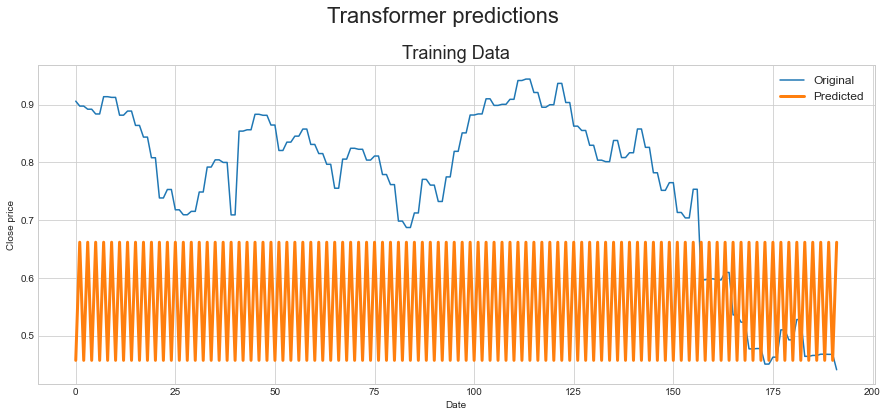

In [259]:
original, predictions = predict(model, src_mask, tgt_mask, [loader_test], batch_size, n_heads)
draw_prediction(original, predictions)

## Native transformer.

In [260]:
class Time2Vector(nn.Module):
    
    def __init__(self, sequnce_size: int = 1, feature_num: int = 1):
        """
        Apply time to vector embedding.

        Args:
            sequnce_size: size of event sequence in time
            feature_num: number of features in sequence
        """
        super(Time2Vector, self).__init__()
        
        self.sequnce_size = sequnce_size
        self.feature_num = feature_num
        self.weights_linear = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_linear = torch.nn.Parameter(torch.empty(feature_num))
        self.weights_periodic = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_periodic = torch.nn.Parameter(torch.empty(feature_num))
        self.func_periodic = torch.sin
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Initialize component weights
        """
        # init linear weights
        nn.init.uniform_(self.weights_linear, -1, 1)
        nn.init.uniform_(self.bias_linear, -1, 1)
        
        # init periodic weights
        nn.init.uniform_(self.weights_periodic, -1, 1)
        nn.init.uniform_(self.bias_periodic, -1, 1)

    def forward(self, x):
        weights_linear = self.weights_linear.expand(x.shape[0], self.sequnce_size, self.feature_num)
        linear = torch.mul(weights_linear, x) + self.bias_linear
        weights_periodic = self.weights_periodic.expand(x.shape[0], self.sequnce_size, self.feature_num)
        periodic = self.func_periodic(torch.mul(weights_periodic, x) + self.bias_periodic)
        return torch.cat([linear, periodic], 2)

In [262]:
sequence_lenght = 5
num_features = 1
time2vec = Time2Vector(sequence_lenght, num_features)

data = torch.rand((7, sequence_lenght, num_features))
output = time2vec(data)
print(f"Output shape: ${output.shape}")

Output shape: $torch.Size([7, 5, 2])


In [469]:
# TODO use PyTorch transformer directly.
class TimeSeriesTransformerTime2Vec(nn.Module):
    def __init__(
        self,
        input_size: int,
        dec_seq_len: int,
        max_seq_len: int,
        out_seq_len: int=58,
        dim_val: int=512,
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
    ):

        """
        Args:
            input_size: int, the number of input variables
            dec_seq_len: int, length of decoder input
            max_seq_len: int, longest sequence the model will process, used for positional encoding
            out_seq_len: int, length of the target sequence, i.e. how many time steps should your forecast cover
            dim_val: int, number of expected features in the input
            n_encoder_layers: int, number of decoder layers in decoder
            n_decoder_layers: int, number of encoder layers in encoder
            n_heads: int, number of attention heads, dim_val must be divisible by this number
            dropout_encoder: float, dropout rate of the encoder
            dropout_decoder: float, dropout rate of the decoder
            dropout_pos_enc: float, dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in feed forward layer inside the encoder layers
            dim_feedforward_decoder: int, number of neurons in feed forward layer inside the decoder layers
        """
        super().__init__()

        self.dec_seq_len = dec_seq_len

        self.time_encoding_layer = Time2Vector(
            sequnce_size=max_seq_len,
            feature_num=1
        )

        self.tgt_time_encoding_layer = Time2Vector(
            sequnce_size=2,
            feature_num=1
        )

        self.transformer_input_layer = nn.Linear(
            in_features=3, 
            out_features=dim_val
        )

        self.transformer_tgt_input_layer = nn.Linear(
            in_features=3, 
            out_features=dim_val
        )

        self.transformer = nn.Transformer(
            d_model = dim_val,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dropout=0.2, 
            batch_first=True)

        self.transformer_output_layer = nn.Linear(
            in_features=128,
            out_features=1
        )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, tgt_mask: Tensor=None) -> Tensor:
        """
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the feature number
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, E is the feature number.
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """
        src_time_vector = self.time_encoding_layer(src)
        tgt_time_vector = self.tgt_time_encoding_layer(tgt)
        src = torch.cat([src, src_time_vector], 2)
        tgt = torch.cat([tgt, tgt_time_vector], 2)
        # print(f"Src with time2vec shape: {src.shape}")
        src = self.transformer_input_layer(src)
        tgt = self.transformer_tgt_input_layer(tgt)
        # print(f"Transformer src input shape: {src.shape}")
        # print(f"Transformer tgt input shape: {tgt.shape}")
        src = self.transformer(
            src,
            tgt,
            # src_mask = src_mask,
            # tgt_mask = tgt_mask
        )
        # print(f"Transformer output shape: {src.shape}")
        src = self.transformer_output_layer(src)
        src = src.flatten(start_dim=1)
        # print(f"Transformer output shape: {src.shape}")
        return src

In [470]:
## TODO
# 1. Apply mask
# 2. Apply bigger interval
# 3. Play with simple generated data

## Model parameters
dim_val = 128 # number of expected features in the input
n_heads = 8 # number of attention heads, dim_val must be divisible by this number
n_decoder_layers = 4 # number of decoder layers in decoder
n_encoder_layers = 4 # number of encoder layers in encoder
input_size = 2 # number of input variables //TODO ???
dec_seq_len = 2 # length of decoder input
enc_seq_len = seq_len # length of encoder input
output_sequence_length = 2 # length of target sequence, i.e. how many time steps should your forecast cover
in_features_encoder_linear_layer = 512 # number of neurons in feed forward layer inside the encoder layers
in_features_decoder_linear_layer = 512 # number of neurons in feed forward layer inside the decoder layers
max_seq_len = seq_len # longest sequence the model will process, used for positional encoding
dropout_encoder = 0.1 # dropout rate of the encoder
dropout_decoder = 0.1 # dropout rate of the decoder
dropout_pos_enc = 0.1 # dropout rate of the positional encoder

model = TimeSeriesTransformerTime2Vec(
  input_size=input_size,  
  dec_seq_len=dec_seq_len,
  max_seq_len=max_seq_len,
  out_seq_len=output_sequence_length,
  dim_val=dim_val,   
  n_decoder_layers=n_decoder_layers,
  n_encoder_layers=n_encoder_layers,
  n_heads=n_heads,
  dropout_encoder=dropout_encoder,
  dropout_decoder=dropout_decoder,
  dropout_pos_enc=dropout_pos_enc,
  dim_feedforward_encoder=in_features_encoder_linear_layer,
  dim_feedforward_decoder=in_features_decoder_linear_layer
)

Shape src_mask: $torch.Size([256, 56, 56])
Shape tgt_mask: $torch.Size([256, 2, 2])
Epoch 1
-------------------------------
Train loss: 0.237626

Test loss: 0.164583
Epoch 1 train loss: 0.2376261175920566
Epoch 1 valid loss: 0.16458292553822199
Epoch 2
-------------------------------
Train loss: 0.182482

Test loss: 0.004991
Epoch 2 train loss: 0.18248217652241389
Epoch 2 valid loss: 0.004991153934194396
Epoch 3
-------------------------------
Train loss: 0.106725

Test loss: 0.017978
Epoch 3 train loss: 0.10672450593362252
Epoch 3 valid loss: 0.017978018925835688
Epoch 4
-------------------------------
Train loss: 0.110992

Test loss: 0.018453
Epoch 4 train loss: 0.11099249264225364
Epoch 4 valid loss: 0.01845263394837578
Epoch 5
-------------------------------
Train loss: 0.102205

Test loss: 0.031921
Epoch 5 train loss: 0.1022053045531114
Epoch 5 valid loss: 0.031921470848222576
Epoch 6
-------------------------------
Train loss: 0.098237

Test loss: 0.040193
Epoch 6 train loss: 0.0

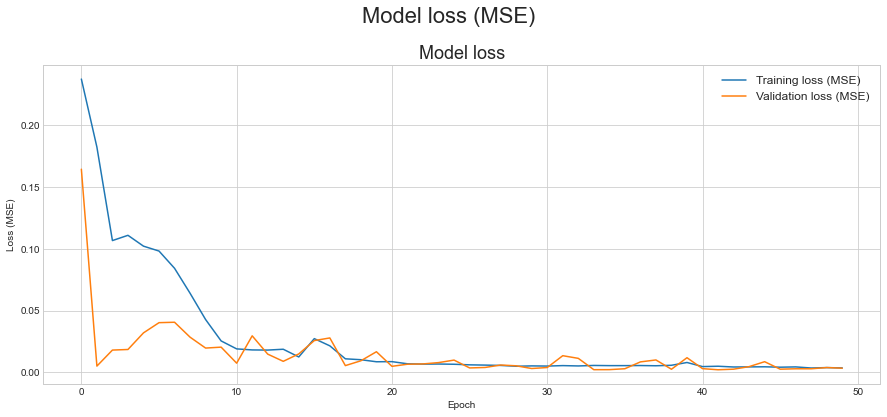

In [471]:
# Learning rate 0.0001
# Epochs 15

epochs = 50

# dim1: int, batch_size * n_heads
# dim2: int. For src and trg masking this must be target sequence length. 
# dim3: int. For src masking, this must be encoder sequence length.
#       For trg masking, this must be target sequence length 
src_mask = generate_square_subsequent_mask(
    dim1=batch_size*n_heads,
    dim2=enc_seq_len,
    dim3=enc_seq_len
)
tgt_mask = generate_square_subsequent_mask( 
    dim1=batch_size*n_heads,
    dim2=output_sequence_length,
    dim3=output_sequence_length
)
# src_mask = nn.Transformer.generate_square_subsequent_mask(enc_seq_len)
# tgt_mask = nn.Transformer.generate_square_subsequent_mask(output_sequence_length)
print(f"Shape src_mask: ${src_mask.shape}")
print(f"Shape tgt_mask: ${tgt_mask.shape}")
train_losses, valid_losses = train_model(model, src_mask, tgt_mask, loader_train, loader_valid, epochs=epochs, lr=0.0001, batch_size=batch_size, n_heads=n_heads)
plot_losses(train_losses, valid_losses)

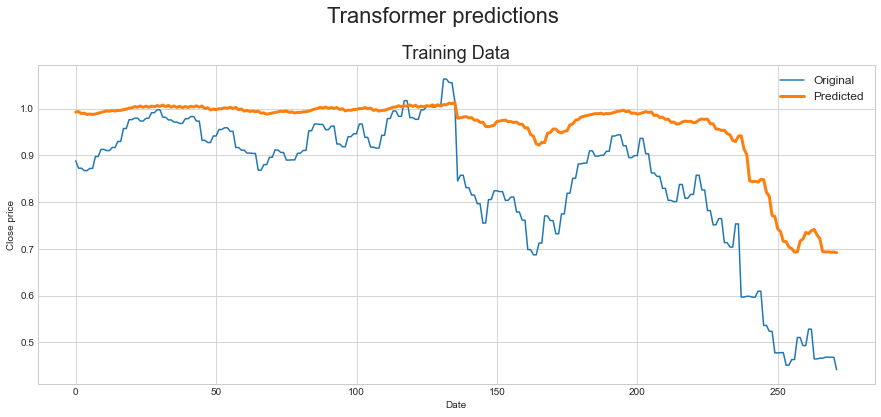

In [473]:
original, predictions = predict(model, src_mask, tgt_mask, [loader_valid, loader_test], batch_size, n_heads)
draw_prediction(original, predictions)

In [ ]:
# Define some hyperparameters
enc_seq_len = 4 # length of input given to encoder
shiftn_forward = 1 # shift forward
shift_backward = 1 # shift backward

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
})
src, trg, trg_y = split_to_sequences(enc_seq_len, 1, 1, df, "c")
print(src)
print(trg)
print(trg_y)

[[ 100  200  300  400]
 [ 200  300  400  500]
 [ 300  400  500  600]
 [ 400  500  600  700]
 [ 500  600  700  800]
 [ 600  700  800  900]
 [ 700  800  900 1000]
 [ 800  900 1000 1100]
 [ 900 1000 1100 1200]
 [1000 1100 1200 1300]
 [1100 1200 1300 1400]
 [1200 1300 1400 1500]
 [1300 1400 1500 1600]
 [1400 1500 1600 1700]]
[[ 400  500]
 [ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]]
[[ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]
 [1800 1900]]


In [215]:
x = torch.tensor([1, 2, 3, 4])
x = torch.unsqueeze(x, 0)
print(x.shape)
x = torch.unsqueeze(x, 1)
print(x.shape)

dummy_data = torch.rand((5, 3))
print(dummy_data)
x = torch.unsqueeze(dummy_data, 2)
print(x.shape)
print(x)

torch.Size([1, 4])
torch.Size([1, 1, 4])
tensor([[1.9787e-01, 3.9686e-01, 4.2174e-01],
        [3.7798e-01, 9.9803e-01, 9.5367e-01],
        [7.1124e-02, 6.3628e-01, 7.7579e-02],
        [2.5553e-04, 3.6915e-01, 6.3521e-01],
        [6.9375e-01, 3.5598e-01, 8.3052e-01]])
torch.Size([5, 3, 1])
tensor([[[1.9787e-01],
         [3.9686e-01],
         [4.2174e-01]],

        [[3.7798e-01],
         [9.9803e-01],
         [9.5367e-01]],

        [[7.1124e-02],
         [6.3628e-01],
         [7.7579e-02]],

        [[2.5553e-04],
         [3.6915e-01],
         [6.3521e-01]],

        [[6.9375e-01],
         [3.5598e-01],
         [8.3052e-01]]])


In [237]:
dummy_data = torch.rand((22, 5, 3))
dim1 = 11
dummy_data = dummy_data[:dim1]
print(dummy_data.shape)

torch.Size([11, 5, 3])


In [391]:
dummy_data = torch.rand((6, 5, 1))
print(dummy_data)
print(dummy_data.flatten(start_dim=1).shape)

tensor([[[0.9051],
         [0.6752],
         [0.7688],
         [0.2911],
         [0.5418]],

        [[0.5380],
         [0.3447],
         [0.5017],
         [0.9592],
         [0.9783]],

        [[0.2809],
         [0.0632],
         [0.8232],
         [0.0461],
         [0.0062]],

        [[0.0933],
         [0.5413],
         [0.3186],
         [0.9173],
         [0.9929]],

        [[0.6785],
         [0.9968],
         [0.1215],
         [0.5946],
         [0.5774]],

        [[0.7787],
         [0.6889],
         [0.2646],
         [0.8097],
         [0.7973]]])
torch.Size([6, 5])
